In [1]:
import cv2 
from PIL import Image
import requests
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
# ЗАГРУЗИТЬ ТЕСТ
test_image = cv2.imread('/Users/nikitaseleznev/Downloads/tsW-xksQfeY.jpg') 

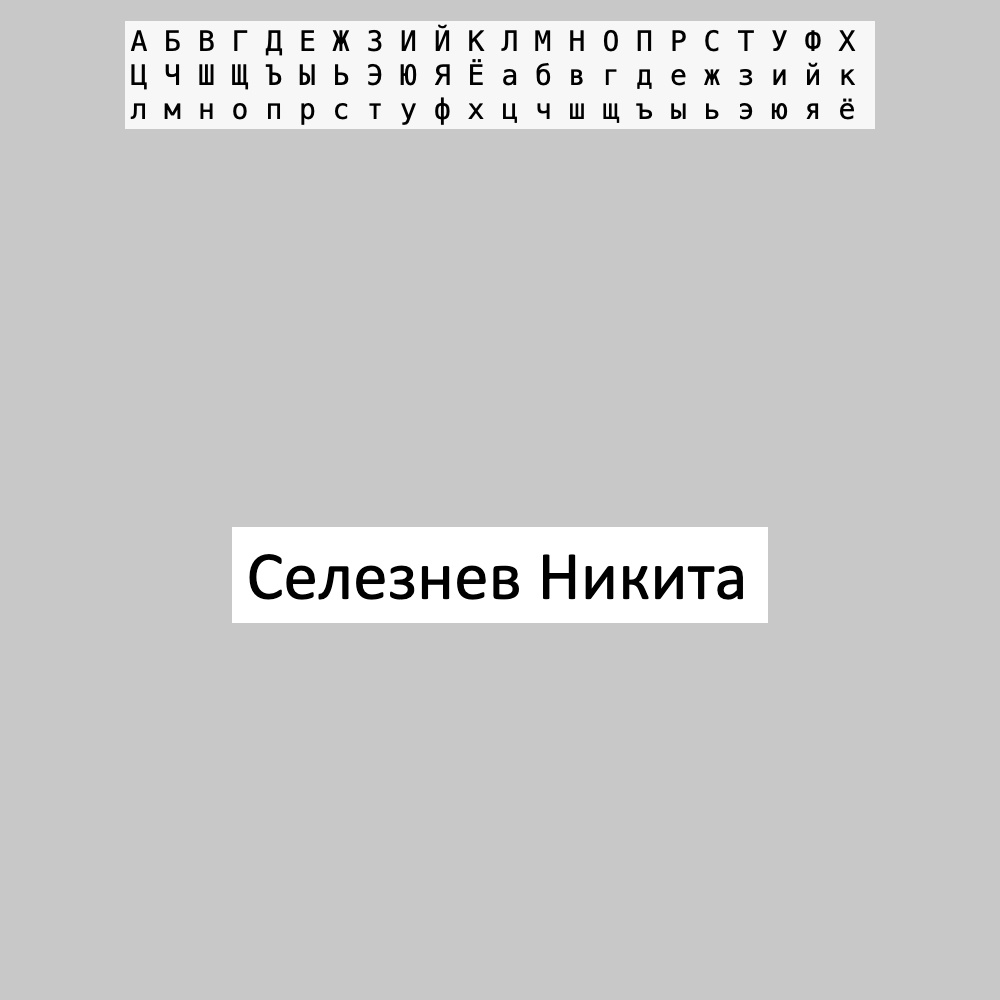

In [3]:
# моя train картинка
response = requests.get('https://raw.githubusercontent.com/NikitaSel/SHARE/main/image_folder/START.jpg', stream=True).raw
my_pil_image = Image.open(response)
display(my_pil_image)

In [4]:
def search_name(test_image, image_size=(10, 10)):
    image = np.array(my_pil_image)#cv2.imread('/Users/nikitaseleznev/Downloads/START.jpg')
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)
    
    #вырезаю нужные мне части
    char_image = image[21:21+108, 125:125+750]
    train_image = image[377 + 150:377 + 150 +96, 232:232+536] 

    #обработка алфавита(char_image) для выделения букв
    gray = cv2.cvtColor(char_image, cv2.COLOR_BGR2GRAY)     
    blur = cv2.GaussianBlur(gray, (5, 5), 0)                 
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)  
    
    # ядро для "склейки" таких букв как ы Й ё
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 7))
    morf_char = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # выделяю буквы из словаря
    contour_char, _ = cv2.findContours(morf_char, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    
    char_image_copy = char_image.copy()
    for cnt in contour_char:
        [x, y, w, h] = cv2.boundingRect(cnt)
        cv2.rectangle(char_image_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
    # даю буквам лейблы от 0 до 66 и обучаю на них
    samples = np.empty((0, 100), np.float32)
    responses = []
    i = 0
    for cnt in contour_char:    
        [x, y, w, h] = cv2.boundingRect(cnt)
        key = i
        responses.append(key) 
        roi = thresh[y:y + h, x:x + w]
        roismall = cv2.resize(roi, (10, 10)) 
        sample = roismall.reshape((1, 100)) 
        samples = np.append(samples, sample, 0)                
        i += 1   

    responses = np.array(responses, np.float32)
    responses = responses.reshape((responses.size, 1))

    samples = np.float32(samples)
    responses = np.float32(responses)
    
    model = cv2.ml.KNearest_create()
    model.train(samples, cv2.ml.ROW_SAMPLE, responses)
    
    # Выделяю буквы для моего имени и фамилии
    gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)      
    blur = cv2.GaussianBlur(gray, (5, 5), 0)                  
    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)   

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10))

    morf_train = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contour, _ = cv2.findContours(morf_train, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    
    # прохожу по буквам, сотавляю для моего имени и фамилии вектор(66 координат)
    # прибавляю к координате 1, если есть буква
    train_image_copy = train_image.copy()
    r = np.zeros((1, 66), dtype=int)
    for cnt in contour:   
        [x, y, w, h] = cv2.boundingRect(cnt) 
        cv2.rectangle(train_image_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
        roi = thresh[y:y + h, x:x + w]
        roismall = cv2.resize(roi, (10, 10))
        roismall = roismall.reshape((1, 100))
        roismall = np.float32(roismall)
        retval, results, neigh_resp, dists = model.findNearest(roismall, k=1)
        r[0, int(results[0][0])] += 1

   # обрабатываю тестовую картинку
    gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)                     
    thresh = cv2.adaptiveThreshold(gray, 255, 1, 1, 15, 25)
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel2 = np.ones((2,2),np.uint8)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)

    thresh = closing

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (24, 3))

    morf = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contour_floded, _ = cv2.findContours(morf, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    
    # для тестовой картинке прохожу по строчкам и читаю буквы, из строчек 
    # составляю вектора, а потом считаю их близость по косинусу и выбираю наиближайший вектор
    test_image_copy = test_image.copy()
    s = np.zeros((0, 66), dtype=int)
    m = []
    for cnt in contour_floded:
        [x, y, w, h] = cv2.boundingRect(cnt)

        roi = thresh[y:y + h, x:x + w]
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 4))

        morf_test = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)
        contour, _ = cv2.findContours(morf_test, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)

        m.append([x, y, w, h])
        tmp_array = np.zeros((1, 66), dtype=int)
        for cont in contour:
            [x, y, w, h] = cv2.boundingRect(cont)
            roi1 = roi[y:y + h, x:x + w]
            copy = roi1.copy()
            roismall = cv2.resize(roi1, (10, 10))
            roismall = roismall.reshape((1, 100))
            roismall = np.float32(roismall)
            retval, results, neigh_resp, dists = model.findNearest(roismall, k=1)
            tmp_array[0, int(results[0][0])] += 1

        s = np.vstack([s, tmp_array])
    
    # считаю близость моей имени и фамилии с другими
    cos_similarity = []
    for elem in s:
        r2 = np.sqrt((r @ r.T)[0][0])
        elem2 = np.sqrt(elem.T @ elem)
        r_s = r @ elem[:, np.newaxis]
        cos_similarity.append((r_s/r2/elem2)[0][0])
    cos_similarity = np.array(cos_similarity)
    
    # обвожу в рамку лучший вариант
    [x, y, w, h] = m[cos_similarity.argmax()]
    cv2.rectangle(test_image_copy, (x, y), (x + w, y + h), (0, 0, 255), 2)
    plt.figure(figsize=image_size)
    plt.imshow(test_image_copy, cmap='gray')

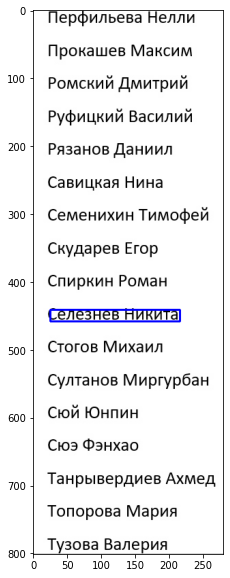

In [5]:
search_name(test_image=test_image)